# Udacity Capstone Project
Stock market prediction in this capstone project is treated as a classification problem, where the objective is to predict whether the cumulative returns of a stock over a period of one day will be greater than zero (up) or smaller (down). The final algorithm has to return (1) the predicted label and (2) a confidence level. 

The final classification algorithm will be used in a long/short equity trading strategy. Using a ranking scheme based on both the predicted label and the algorithms confidence the strategy goes long on (buys) the top x% of equities of the ranking and goes short on (sells) the bottom x% of the ranking, while maintaining equal dollar volume between the long and short position (Granizo-Mackenzie). The implementation of the machine learning algorithm is out of the scope of this capstone project, yet relevant for the implementation of the algorithm and its evaluation metric.

This Capstone project will follow the Professional Quant Equity Workflow proposed by Jonathan Larkin, Chief Investment Officer at Quantopian.

1. **Data** — There are endless data sources available, yet most are locked behind a paywall. Researching datasets and ultimately selecting datasets will influence the performance of the algorithm greatly
2. **Stock Universe** — Thousands of securities can be traded, which doesn’t imply that one should consider these stocks in their trading strategy.Using the TradableUS Methodology (Wassermann, 2016) to select a set of 500 stocks that are tradable, liquid, financially viable and represent sectors equally at the beginning of the training time to avoid survivor bias.
3. **Alpha Discovery** — I’ll be calculating fundamental and technical indicators (alphas) for the stock universe. Each alpha will be evaluated using the `alphalens` package to determine whether the alpha is predictive of future returns.
4. **Alpha Combination** — I intend to develop a system that is an ensemble of multiple machine learning classifiers that combine the individual alphas. The goal of ensembles is that the performance of the entire system is better than the performance of each classifier individually. Another benefit of ensemble systems is that even if one underlying classifier fails, the system can continue to function, which makes it more robust (Qian & Rasheed, 2006).

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import pandas_datareader.data as web
from IPython.display import display
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
import requests_cache
plt.style.use('ggplot')

%matplotlib inline

## Data
In order to limit bandwidth and to avoid running into rate limitations with the API the session below is established, which saves the data for a certain period of time in a sqllite cache.

In [2]:
expire_after = timedelta(days=30)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)

*Historical Daily Pricing Data*: This data will be loaded from Google finance and contains the following continous attributes that will be used in this capstone project:

- Open — first price of a security, after the exchange has opened
- High — maximum price of a security of a given day
- Low — minimum price of a security of a given day
- Close — last price of a security, before the exchange closed
- Adjusted Close — last price of a security, before the exchange closed adjusted for dividends and stock splits
- Volume — the total number of traded shares on a given date for a given security

An important aspect to consider when working with historical price data ist that returns on stocks are not normally distributed - e.g. fatter tails. It is especially important, when selecting algorithms as some work a lot better with normally distributed data.

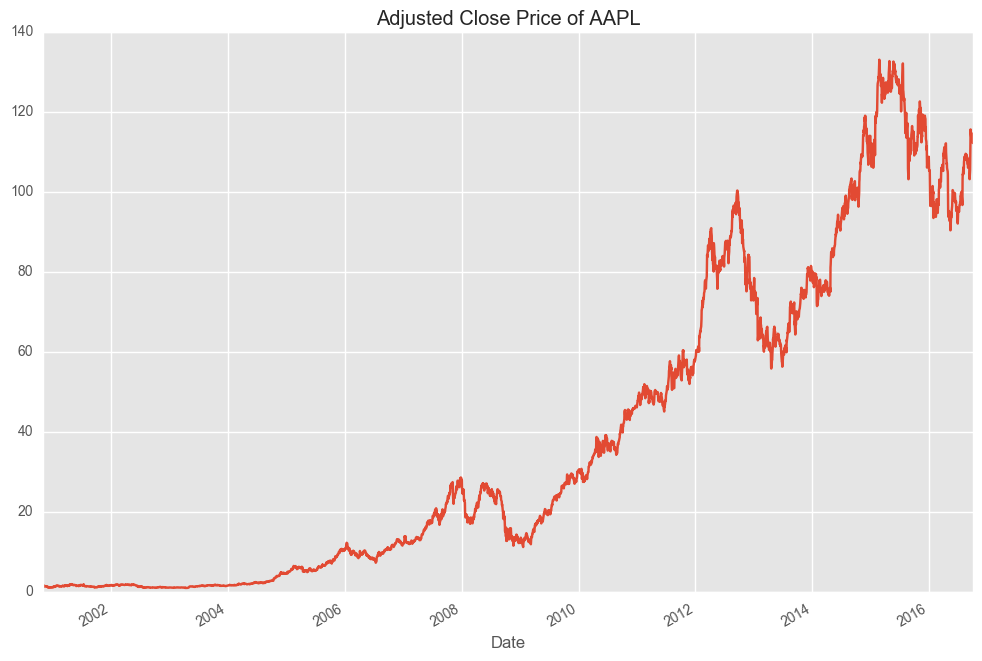

In [3]:
# Sample for Yahoo Historical Data Retrieval
start = datetime(2000,1,1)
end = datetime(2016,10,1)

stock = "aapl"
stock_data = web.DataReader(stock, "google", start, end, session=session)
stock_data["Close"].plot(figsize=(12,8), title='Adjusted Close Price of AAPL');

## Universe Definition
The following dictionary maps the selected stocks to their respective industry. This is important, since I'm expecting that some alphas will be more predivitve for certain industries than others. The stock selection was done in the Quantopian research environment using the methodology described in the project report.

In [4]:
stock_universe_train = {'NYSE:XL': 103, 'NYSE:COP': 309, 'NYSE:EOG': 309, 'NYSE:COX': 308, 'NYSE:EOP': 104, 'NYSE:AVY': 310, 'NYSE:COF': 103, 'NASDAQ:LSI': 311, 'NYSE:AVP': 205, 'NYSE:COH': 102, 'NYSE:SPGI': 310, 'NASDAQ:NVLS': 311, 'NYSE:NWL': 205, 'NYSE:AON': 103, 'NASDAQ:KLAC': 311, 'NYSE:ZBH': 206, 'NYSE:UPS': 310, 'NYSE:SO': 207, 'NASDAQ:VRSN': 311, 'NYSE:CVX': 309, 'NASDAQ:CA': 311, 'NYSE:TWX': 102, 'NYSE:CVS': 205, 'NASDAQ:ICST': 311, 'NASDAQ:CHIR': 206, 'NYSE:PHM': 102, 'NASDAQ:MRVL': 311, 'NYSE:PHA': 206, 'NYSE:CVC': 308, 'NASDAQ:CTAS': 310, 'NYSE:EL': 205, 'NYSE:LUV': 310, 'NASDAQ:BEAS': 311, 'NYSE:ED': 207, 'NYSE:HLT': 102, 'NASDAQ:SIAL': 101, 'NYSE:EP': 309, 'NYSE:GDW': 103, 'NYSE:HLS': 206, 'NASDAQ:ROST': 102, 'NASDAQ:ADSK': 311, 'NYSE:TER': 311, 'NYSE:HES': 309, 'NYSE:HMA': 206, 'NASDAQ:AFFX': 206, 'NYSE:XRX': 311, 'NYSE:PFG': 103, 'NYSE:RYL': 102, 'NYSE:BEAM': 205, 'NYSE:JP': 103, 'NASDAQ:VSEA': 311, 'NASDAQ:XLNX': 311, 'NASDAQ:CREE': 311, 'NASDAQ:MOLX': 311, 'NYSE:MFE': 311, 'NASDAQ:INTU': 311, 'NYSE:AZO': 102, 'NYSE:TSG': 311, 'NYSE:GSF': 309, 'NASDAQ:INTC': 311, 'NYSE:KBH': 102, 'NYSE:BRL': 206, 'NASDAQ:TLAB': 311, 'NASDAQ:TXN': 311, 'NASDAQ:CYMI': 311, 'NYSE:SRE': 207, 'NASDAQ:CMCSA': 308, 'NASDAQ:SLM': 103, 'NYSE:JBL': 311, 'NYSE:NSC': 310, 'NASDAQ:PCAR': 310, 'NYSE:MYG': 102, 'NYSE:LLL': 310, 'NYSE:XOM': 309, 'NASDAQ:DELL': 311, 'NYSE:SDS': 311, 'NYSE:LLY': 206, 'NYSE:HRB': 102, 'NYSE:JPM': 103, 'NASDAQ:HGSI': 206, 'NASDAQ:TECD': 311, 'NASDAQ:CTXS': 311, 'NASDAQ:CTSH': 311, 'NYSE:AEE': 207, 'NYSE:AEO': 102, 'NASDAQ:BMET': 206, 'NASDAQ:NXTL': 308, 'NYSE:IR': 310, 'NYSE:IP': 102, 'NYSE:AET': 206, 'NYSE:BOL': 206, 'NYSE:AEP': 207, 'NYSE:DOV': 310, 'NYSE:DOW': 101, 'NYSE:HOT': 102, 'NYSE:TAP': 205, 'NYSE:PPG': 101, 'NASDAQ:ESST': 311, 'NASDAQ:COST': 205, 'NYSE:PPL': 207, 'NASDAQ:ATVI': 311, 'NASDAQ:SMTC': 311, 'NYSE:HOG': 102, 'NASDAQ:VIAV': 311, 'NYSE:MAS': 101, 'NYSE:TGNA': 102, 'NASDAQ:SNPS': 311, 'NYSE:OHP': 206, 'NYSE:WB': 103, 'NYSE:WM': 310, 'NYSE:DHR': 310, 'NYSE:ELX': 311, 'NYSE:PBI': 310, 'NYSE:DHI': 102, 'NASDAQ:FHCC': 103, 'NASDAQ:ZRAN': 311, 'NYSE:WY': 101, 'NASDAQ:ROOM': 102, 'NYSE:MRK': 206, 'NASDAQ:ODP': 102, 'NYSE:BDK': 310, 'NYSE:BRK.B': 103, 'NASDAQ:CSCO': 311, 'NASDAQ:QCOM': 311, 'NYSE:BDX': 206, 'NYSE:TOY': 102, 'NASDAQ:AMZN': 102, 'NASDAQ:GILD': 206, 'NASDAQ:LLTC': 311, 'NASDAQ:CCMP': 311, 'NYSE:DVN': 309, 'NYSE:SYK': 206, 'NYSE:TOL': 102, 'NASDAQ:CEPH': 206, 'NYSE:SYY': 205, 'NYSE:ROH': 101, 'NASDAQ:ISIL': 311, 'NASDAQ:LIFE': 206, 'NASDAQ:PAYX': 310, 'NASDAQ:ALTR': 311, 'NYSE:CCL': 102, 'NASDAQ:QLGC': 311, 'NYSE:DNA': 206, 'NASDAQ:ATML': 311, 'NYSE:HON': 310, 'NYSE:FOX': 102, 'NASDAQ:LNCR': 206, 'NYSE:LOW': 102, 'NYSE:TIF': 102, 'NASDAQ:BBBY': 102, 'NASDAQ:MLNM': 206, 'NASDAQ:ADVP': 206, 'NYSE:MER': 103, 'NASDAQ:ADVS': 311, 'NYSE:MET': 103, 'NYSE:NYT': 102, 'NASDAQ:ITMN': 206, 'NYSE:GLW': 311, 'NYSE:MWW': 310, 'NYSE:AIG': 103, 'NASDAQ:CMVT': 311, 'NYSE:MO': 205, 'NASDAQ:ADP': 310, 'NYSE:MS': 103, 'NASDAQ:ADI': 311, 'NYSE:CIEN': 311, 'NYSE:IGT': 102, 'NYSE:RE': 103, 'NYSE:AWE': 308, 'NYSE:CLX': 205, 'NASDAQ:GMST': 311, 'NYSE:PFE': 206, 'NYSE:SCHW': 103, 'NASDAQ:PDLI': 206, 'NYSE:NVR': 102, 'NASDAQ:BIIB': 206, 'NYSE:SWY': 205, 'NYSE:APA': 309, 'NYSE:APC': 309, 'NYSE:APD': 101, 'NASDAQ:SWKS': 311, 'NASDAQ:TTWO': 311, 'NYSE:SEE': 102, 'NYSE:DRI': 102, 'NASDAQ:PTEN': 309, 'NASDAQ:MEDI': 206, 'NYSE:ECL': 101, 'NYSE:MON': 101, 'NASDAQ:VRTS': 101, 'NYSE:CSC': 311, 'NASDAQ:DOX': 311, 'NYSE:ALL': 103, 'NYSE:UHS': 206, 'NYSE:DD': 101, 'NYSE:EQR': 104, 'NYSE:IRF': 311, 'NYSE:BJS': 309, 'NASDAQ:PNRA': 102, 'NYSE:ABT': 206, 'NYSE:ABS': 205, 'NYSE:MRO': 309, 'NYSE:SLB': 309, 'NYSE:MAN': 310, 'NYSE:TDW': 309, 'NYSE:RATL': 311, 'NYSE:ABI': 311, 'NYSE:SLR': 311, 'NASDAQ:ADRX': 205, 'NYSE:MAY': 102, 'NYSE:NKE': 102, 'NASDAQ:RCII': 102, 'NYSE:WHR': 311, 'NYSE:EMN': 101, 'NYSE:EMC': 311, 'NYSE:CAT': 310, 'NYSE:CAM': 309, 'NYSE:CAH': 206, 'NYSE:VZ': 308, 'NYSE:EMR': 310, 'NYSE:CAG': 205, 'NYSE:BSC': 103, 'NYSE:AAP': 102, 'NYSE:MSI': 311, 'NYSE:NUE': 101, 'NASDAQ:CECO': 205, 'NYSE:MHK': 102, 'NASDAQ:JAVA': 311, 'NASDAQ:ZION': 103, 'NASDAQ:CSX': 310, 'NYSE:GDT': 206, 'NYSE:FE': 207, 'NYSE:UCL': 309, 'NASDAQ:IDTI': 311, 'NYSE:TRI': 206, 'NASDAQ:MAT': 102, 'NASDAQ:MAR': 102, 'NASDAQ:EXTR': 311, 'NYSE:DE': 310, 'NYSE:FDC': 310, 'NYSE:TRV': 103, 'NYSE:GPT': 103, 'NYSE:GPS': 102, 'NYSE:TAP_A': 103, 'NYSE:CHS': 102, 'NYSE:WSM': 102, 'NASDAQ:ACDO': 206, 'NYSE:CB': 103, 'NYSE:CE': 310, 'NYSE:CF': 103, 'NYSE:CI': 206, 'NYSE:CL': 205, 'NYSE:YUM': 102, 'NYSE:ARNC': 101, 'NYSE:ABC': 206, 'NYSE:SAF': 103, 'NASDAQ:LPNT': 206, 'NYSE:LNC': 103, 'NYSE:TGT': 205, 'NYSE:UVN': 102, 'NASDAQ:CYTC': 206, 'NYSE:GIS': 205, 'NYSE:CFC': 103, 'NYSE:BNI': 310, 'NYSE:WAT': 206, 'NYSE:AFL': 103, 'NYSE:HD': 102, 'NYSE:MTB': 103, 'NYSE:PEP': 205, 'NYSE:MTG': 103, 'NYSE:JCI': 310, 'NYSE:HNZ': 205, 'NYSE:MMC': 103, 'NYSE:BAC': 103, 'NYSE:PGR': 103, 'NYSE:MMM': 310, 'NASDAQ:AMCC': 311, 'NASDAQ:SYMC': 311, 'NASDAQ:SOTR': 103, 'NYSE:AXP': 103, 'NASDAQ:MXIM': 311, 'NASDAQ:YHOO': 311, 'NYSE:EIX': 207, 'NASDAQ:ESRX': 206, 'NYSE:STJ': 206, 'NYSE:STI': 103, 'NYSE:CMA': 103, 'NYSE:WYE': 206, 'NYSE:PEG': 207, 'NASDAQ:NTRS': 103, 'NYSE:CMX': 205, 'NYSE:WLP': 206, 'NYSE:KMB': 205, 'NYSE:KMG': 309, 'NYSE:KMI': 207, 'NASDAQ:ENZN': 206, 'NYSE:STT': 103, 'NYSE:VLO': 309, 'NYSE:ORCL': 311, 'NASDAQ:EA': 311, 'NASDAQ:CAR': 310, 'NYSE:DUK': 207, 'NASDAQ:RFMD': 311, 'NASDAQ:DISH': 308, 'NYSE:JNS': 103, 'NYSE:SFA': 311, 'NYSE:JNJ': 206, 'NYSE:JNY': 102, 'NYSE:LEN': 102, 'NYSE:CTX': 102, 'NASDAQ:FITB': 103, 'NASDAQ:SNDK': 311, 'NYSE:WWY': 205, 'NYSE:CTL': 308, 'NASDAQ:CHKP': 311, 'NYSE:PNC': 103, 'NASDAQ:PFCB': 102, 'NYSE:NCC': 103, 'NYSE:MIK': 102, 'NYSE:GP': 101, 'NYSE:GS': 103, 'NYSE:ACF': 103, 'NASDAQ:MYL': 206, 'NYSE:ACL': 206, 'NYSE:ACN': 311, 'NYSE:GE': 310, 'NYSE:GD': 310, 'NYSE:ACS': 311, 'NYSE:BMY': 206, 'NASDAQ:BRCD': 311, 'NASDAQ:DLTR': 205, 'NASDAQ:BRCM': 311, 'NYSE:USB': 103, 'NYSE:DGX': 206, 'NYSE:MBI': 103, 'NYSE:HIG': 103, 'NYSE:MBG': 102, 'NYSE:PRU': 103, 'NYSE:G': 205, 'NYSE:CBE': 311, 'NYSE:D': 207, 'NYSE:C': 103, 'NYSE:RSH': 102, 'NYSE:A': 206, 'NASDAQ:ISSX': 311, 'NYSE:M': 102, 'NYSE:L': 102, 'NYSE:K': 205, 'NYSE:WEN': 102, 'NYSE:S': 102, 'NYSE:Q': 308, 'NYSE:PBG': 205, 'NYSE:KRI': 102, 'NYSE:LH': 206, 'NYSE:KRB': 103, 'NYSE:BBY': 102, 'NYSE:LU': 311, 'NYSE:PGN': 207, 'NYSE:BBT': 103, 'NYSE:OMC': 102, 'NASDAQ:SPLS': 102, 'NASDAQ:AMAT': 311, 'NASDAQ:PETM': 102, 'NASDAQ:CERN': 311, 'NASDAQ:INVN': 311, 'NYSE:TXU': 207, 'NYSE:TXT': 310, 'NYSE:CIN': 207, 'NASDAQ:AAPL': 311, 'NYSE:SPG': 104, 'NYSE:TJX': 102, 'NYSE:FDX': 310, 'NASDAQ:GENZ': 206, 'NYSE:FDO': 205, 'NYSE:HPQ': 311, 'NASDAQ:IMCL': 206, 'NYSE:WFC': 103, 'NYSE:BAX': 206, 'NYSE:MUR': 309, 'NYSE:KR': 205, 'NASDAQ:NVDA': 311, 'NASDAQ:PMCS': 311, 'NYSE:WFT': 309, 'NASDAQ:SBUX': 102, 'NYSE:AGN': 206, 'NYSE:KO': 205, 'NYSE:KG': 206, 'NYSE:ONE': 103, 'NYSE:SII': 309, 'NYSE:RTN': 310, 'NASDAQ:OVER': 311, 'NYSE:OXY': 309, 'NYSE:SEBL': 311, 'NASDAQ:MSFT': 311, 'NASDAQ:COCO': 205, 'NYSE:ANF': 102, 'NYSE:MEL': 103, 'NYSE:PX': 101, 'NYSE:PD': 101, 'NYSE:PG': 205, 'NASDAQ:AMGN': 206, 'NYSE:PH': 310, 'NYSE:LXK': 311, 'NYSE:ANN': 102, 'NYSE:SGP': 206, 'NYSE:NOC': 310, 'NYSE:HSH': 205, 'NASDAQ:APOL': 205, 'NYSE:DTE': 207, 'NYSE:RDN': 103, 'NYSE:RAI': 205, 'NYSE:DO': 309, 'NYSE:JHF': 103, 'NASDAQ:FISV': 310, 'NYSE:EAT': 102, 'NYSE:ANTM': 206, 'NASDAQ:MU': 311, 'NYSE:BHI': 309, 'NYSE:BJ': 205, 'NYSE:BK': 103, 'NYSE:PCS': 308, 'NYSE:NFB': 103, 'NASDAQ:SLAB': 311, 'NYSE:UNP': 310, 'NYSE:BA': 310, 'NASDAQ:AMD': 311, 'NYSE:UNH': 206, 'NYSE:IPG': 102, 'NASDAQ:NTAP': 311, 'NYSE:BR': 309, 'NYSE:LMT': 310, 'NASDAQ:PLCM': 311, 'NYSE:MGM': 102, 'NASDAQ:PSFT': 101, 'NYSE:EXC': 207, 'NYSE:CCE': 205, 'NYSE:DIS': 102, 'NYSE:IBM': 311, 'NASDAQ:MCHP': 311, 'NASDAQ:ADBE': 311, 'NYSE:CCU': 102, 'NYSE:PCG': 207, 'NYSE:BEN': 103, 'NASDAQ:JBLU': 310, 'NYSE:OA': 310, 'NYSE:BEC': 206, 'NASDAQ:ICOS': 206, 'NYSE:SPXC': 310, 'NYSE:HSY': 205, 'NYSE:KSS': 102, 'NYSE:KEY': 103, 'NYSE:FRX': 206, 'NYSE:AYE': 207, 'NASDAQ:IAC': 311, 'NASDAQ:GNSS': 311, 'NYSE:BSX': 206, 'NYSE:WMB': 309, 'NYSE:PDG': 101, 'NASDAQ:FLEX': 311, 'NYSE:TT': 310, 'NYSE:WMT': 205, 'NYSE:TE': 207, 'NYSE:JCP': 102, 'NASDAQ:LRCX': 311, 'NYSE:F': 102, 'NYSE:KKD': 102, 'NYSE:JNPR': 311, 'NASDAQ:PALM': 311, 'NYSE:UST': 205, 'NYSE:ETR': 207, 'NYSE:AT': 308, 'NASDAQ:CAKE': 102, 'NASDAQ:GT': 102, 'NYSE:TIN': 101, 'NASDAQ:LAMR': 102, 'NYSE:UTX': 310, 'NASDAQ:WFM': 205, 'NASDAQ:WBA': 205, 'NASDAQ:EBAY': 102, 'NYSE:NLS': 102, 'NYSE:MDT': 206, 'NYSE:ESV': 309, 'NYSE:CBH': 103, 'NYSE:HAL': 309, 'NYSE:BLL': 102, 'NYSE:NBR': 309, 'NASDAQ:FCS': 311, 'NYSE:FBF': 103, 'NYSE:XEL': 207, 'NYSE:MCO': 310, 'NYSE:T': 308, 'NYSE:NEE': 207, 'NYSE:MCK': 206, 'NYSE:ITT': 310, 'NYSE:MCD': 102, 'NYSE:ITW': 310, 'NYSE:NEM': 101}

In [86]:
stock_universe_test = {'NYSE:COP': 309, 'NYSE:COV': 206, 'NYSE:EOG': 309, 'NYSE:AVB': 104, 'NYSE:MPC': 309, 'NASDAQ:PLUG': 311, 'NASDAQ:LBTYA': 308, 'NYSE:COG': 309, 'NYSE:COF': 103, 'NASDAQ:ULTA': 102, 'NYSE:COH': 102, 'NYSE:COO': 206, 'NYSE:SPGI': 310, 'NYSE:PGR': 103, 'NASDAQ:HBAN': 103, 'NYSE:AON': 103, 'NASDAQ:KLAC': 311, 'NYSE:ZBH': 206, 'NYSE:UPS': 310, 'NYSE:SM': 309, 'NYSE:SO': 207, 'NYSEMKT:LNG': 309, 'NASDAQ:GRPN': 311, 'NYSE:RAX': 311, 'NYSE:BWA': 102, 'NASDAQ:WIN': 308, 'NYSE:CVX': 309, 'NYSE:TWX': 102, 'NYSE:CVS': 206, 'NYSE:TWC': 308, 'NYSE:PHM': 102, 'NASDAQ:MRVL': 311, 'NYSE:EL': 205, 'NYSE:LUV': 310, 'NYSE:HLF': 205, 'NASDAQ:EQIX': 311, 'NYSE:ED': 207, 'NASDAQ:JAZZ': 206, 'NYSE:ZTS': 206, 'NYSE:PANW': 311, 'NYSE:HLT': 102, 'NYSE:MOS': 101, 'NYSE:AAP': 102, 'NYSE:EW': 206, 'NASDAQ:ROST': 102, 'NYSE:PLD': 104, 'NYSE:VTR': 104, 'NYSE:TEL': 311, 'NASDAQ:ADSK': 311, 'NASDAQ:NFLX': 308, 'NYSE:HES': 309, 'NASDAQ:FOXA': 102, 'NASDAQ:PCLN': 102, 'NYSE:XRX': 311, 'NYSE:LNKD': 311, 'NASDAQ:CHRW': 310, 'NASDAQ:XLNX': 311, 'NASDAQ:CREE': 311, 'NYSE:PRGO': 206, 'NYSE:VFC': 102, 'NYSE:TSO': 309, 'NASDAQ:INTU': 311, 'NASDAQ:CELG': 206, 'NYSE:AZO': 102, 'NASDAQ:GOOGL': 311, 'NASDAQ:ALXN': 206, 'NASDAQ:INTC': 311, 'NASDAQ:AMGN': 206, 'NASDAQ:TXN': 311, 'NYSE:SRE': 207, 'NASDAQ:GRMN': 311, 'NYSE:DAL': 310, 'NASDAQ:TROW': 103, 'NASDAQ:PCAR': 310, 'NASDAQ:ENDP': 206, 'NYSE:UA': 102, 'NASDAQ:KRFT': 205, 'NYSE:ASH': 101, 'NYSE:LLL': 310, 'NYSE:XOM': 309, 'NASDAQ:SBAC': 308, 'NYSE:LLY': 206, 'NYSE:FCX': 101, 'NYSE:JPM': 103, 'NYSE:HRI': 310, 'NASDAQ:CTXS': 311, 'NASDAQ:CTSH': 311, 'NYSE:CRM': 311, 'NYSE:AEP': 207, 'NYSE:IR': 310, 'NYSE:IP': 102, 'NYSE:AET': 206, 'NASDAQ:AMZN': 102, 'NYSE:DOV': 310, 'NYSE:DOW': 101, 'NYSE:HOT': 102, 'NYSE:TAP': 205, 'NYSE:PPG': 101, 'NASDAQ:COST': 205, 'NYSE:PPL': 207, 'NASDAQ:ATVI': 311, 'NYSE:HOG': 102, 'NYSE:RL': 102, 'NYSE:HON': 310, 'NYSE:MLM': 101, 'NYSE:FTI': 309, 'NYSE:WM': 310, 'NYSE:RRC': 309, 'NYSE:DHR': 310, 'NYSE:WU': 103, 'NYSE:DHI': 102, 'NYSE:KORS': 102, 'NYSE:WY': 101, 'NYSE:MRK': 206, 'NYSE:MRO': 309, 'NASDAQ:TSLA': 102, 'NASDAQ:CSCO': 311, 'NYSE:NE': 309, 'NASDAQ:QCOM': 311, 'NYSE:BDX': 206, 'NYSE:OCN': 103, 'NYSE:LVLT': 308, 'NASDAQ:GILD': 206, 'NASDAQ:LLTC': 311, 'NASDAQ:ILMN': 206, 'NYSE:DVN': 309, 'NYSE:SYK': 206, 'NYSE:GWW': 310, 'NYSE:TOL': 102, 'NYSE:WYN': 102, 'NASDAQ:AAPL': 311, 'NYSE:SYY': 205, 'NYSE:ROK': 310, 'NASDAQ:ICPT': 206, 'NASDAQ:PAYX': 310, 'NASDAQ:ALTR': 311, 'NYSE:CCL': 102, 'NASDAQ:ZNGA': 311, 'NYSE:YELP': 311, 'NYSE:ICE': 103, 'NYSE:CYH': 206, 'NYSE:LOW': 102, 'NYSE:NOC': 310, 'NASDAQ:BBBY': 102, 'NASDAQ:FFIV': 311, 'NYSE:NOV': 309, 'NYSE:NOW': 311, 'NASDAQ:AKAM': 311, 'NYSE:BCR': 206, 'NYSE:GLW': 311, 'NYSE:DLPH': 102, 'NYSE:ABBV': 206, 'NYSE:AIG': 103, 'NYSE:DKS': 102, 'NYSE:MA': 103, 'NYSE:DRC': 309, 'NYSE:MO': 205, 'NASDAQ:ADP': 310, 'NYSE:MS': 103, 'NASDAQ:ADI': 311, 'NASDAQ:URBN': 102, 'NYSE:IGT': 102, 'NYSE:CLR': 309, 'NYSE:CLX': 205, 'NYSE:CLF': 101, 'NYSE:PFE': 206, 'NASDAQ:ZG': 104, 'NYSE:VER': 104, 'NYSE:SCHW': 103, 'NYSE:SWK': 310, 'NYSE:SWN': 309, 'NASDAQ:FANG': 309, 'NYSE:DDD': 311, 'NASDAQ:BIIB': 206, 'NASDAQ:EA': 311, 'NYSE:RH': 102, 'NYSE:RF': 103, 'NYSE:APA': 309, 'NYSE:APC': 309, 'NYSE:APD': 101, 'NASDAQ:SWKS': 311, 'NASDAQ:YNDX': 311, 'NYSE:DRI': 102, 'NASDAQ:PTEN': 309, 'NASDAQ:REGN': 206, 'NASDAQ:WDC': 311, 'NYSE:ECL': 101, 'NYSE:RCL': 102, 'NYSE:MON': 101, 'NASDAQ:INCY': 206, 'NASDAQ:VRTX': 206, 'NYSE:HCA': 206, 'NYSE:MHK': 102, 'NYSE:EQT': 309, 'NYSE:DD': 101, 'NYSE:EQR': 104, 'NYSE:HCN': 104, 'NYSE:DG': 205, 'NYSE:HCP': 104, 'NASDAQ:PNRA': 102, 'NYSE:NLSN': 310, 'NYSE:ABT': 206, 'NYSE:AKS': 101, 'NYSE:SLB': 309, 'NYSE:PSA': 104, 'NYSE:MBLY': 311, 'NYSE:PSX': 309, 'NASDAQ:FAST': 310, 'NYSE:MAS': 101, 'NYSE:TDC': 311, 'NASDAQ:LULU': 102, 'NYSE:NKE': 102, 'NASDAQ:TRIP': 311, 'NYSE:WHR': 311, 'NYSE:EMN': 101, 'NYSE:DGX': 206, 'NYSE:CAT': 310, 'NYSE:CAM': 309, 'NYSE:CAH': 206, 'NYSE:VZ': 308, 'NYSE:EMR': 310, 'NYSE:CAG': 205, 'NYSE:MSI': 311, 'NYSE:NUE': 101, 'NYSE:AMG': 103, 'NYSE:UHS': 206, 'NYSE:LYB': 101, 'NASDAQ:CSX': 310, 'NYSE:NUS': 205, 'NYSE:EIX': 207, 'NYSE:AMP': 103, 'NASDAQ:TMUS': 308, 'NYSE:TRN': 310, 'NASDAQ:MAT': 102, 'NASDAQ:MAR': 102, 'NYSE:DE': 310, 'NASDAQ:STX': 311, 'NYSE:TRW': 102, 'NYSE:TRV': 103, 'NYSE:GPS': 102, 'NYSE:CHK': 309, 'NYSE:NRG': 207, 'NYSE:CB': 103, 'NYSE:CF': 101, 'NYSE:CI': 206, 'NYSE:CL': 205, 'NYSE:YUM': 102, 'NYSE:CMG': 102, 'NYSE:TWTR': 311, 'NYSE:ARNC': 101, 'NYSE:JWN': 102, 'NYSE:ABC': 206, 'NASDAQ:BMRN': 206, 'NYSE:HUN': 101, 'NASDAQ:SCTY': 311, 'NYSE:HUM': 206, 'NYSE:LNC': 103, 'NYSE:TGT': 205, 'NYSE:GNW': 103, 'NYSE:CFN': 206, 'NASDAQ:CSIQ': 311, 'NYSE:GIS': 205, 'NYSE:HP': 309, 'NYSE:PXD': 309, 'NYSE:AFL': 103, 'NYSE:HD': 102, 'NYSE:DNR': 309, 'NYSE:PEP': 205, 'NYSE:SHW': 101, 'NYSE:OII': 309, 'NYSE:JCI': 310, 'NYSE:MMC': 103, 'NYSE:BAC': 103, 'NYSE:IVZ': 103, 'NYSE:MMM': 310, 'NASDAQ:SYMC': 311, 'NYSE:AXP': 103, 'NASDAQ:MXIM': 311, 'NASDAQ:YHOO': 311, 'NYSE:RIG': 309, 'NYSE:CMI': 310, 'NASDAQ:ESRX': 206, 'NASDAQ:IONS': 206, 'NYSE:STI': 103, 'NYSE:CMA': 103, 'NYSE:KMX': 102, 'NYSE:PEG': 207, 'NYSE:WLL': 309, 'NYSE:KMB': 205, 'NYSE:STZ': 205, 'NASDAQ:GLNG': 310, 'NYSE:KMI': 309, 'NYSE:STT': 103, 'NYSE:ORCL': 311, 'NYSE:VMW': 311, 'NYSE:DUK': 207, 'NASDAQ:CAR': 310, 'NYSE:JNJ': 206, 'NASDAQ:DISH': 308, 'NYSE:LEN': 102, 'NASDAQ:MNST': 205, 'NASDAQ:FITB': 103, 'NASDAQ:SNDK': 311, 'NYSE:PNR': 310, 'NYSE:CTL': 308, 'NYSE:WDAY': 311, 'NYSE:PNC': 103, 'NASDAQ:MDLZ': 205, 'NYSE:GS': 103, 'NASDAQ:MYL': 206, 'NYSE:ACN': 311, 'NYSE:GE': 310, 'NYSE:GD': 310, 'NASDAQ:AGNC': 104, 'NYSE:BMY': 206, 'NASDAQ:DLTR': 205, 'NASDAQ:ATHN': 311, 'NASDAQ:BRCM': 311, 'NYSE:EMC': 311, 'NYSE:PRU': 103, 'NYSE:F': 102, 'NYSE:D': 207, 'NYSE:C': 103, 'NYSE:A': 206, 'NYSE:O': 104, 'NYSE:M': 102, 'NYSE:K': 205, 'NYSE:CBI': 310, 'NYSE:GME': 102, 'NYSE:V': 103, 'NYSE:T': 308, 'NYSE:S': 308, 'NYSE:P': 102, 'NYSE:WEC': 207, 'NYSE:X': 101, 'NYSE:LB': 102, 'NYSE:LH': 206, 'NYSE:LO': 205, 'NYSE:BBY': 102, 'NASDAQ:CHTR': 308, 'NYSE:BBT': 103, 'NYSE:OMC': 102, 'NYSE:CNP': 207, 'NYSE:CPN': 207, 'NYSE:BRK.B': 103, 'NASDAQ:SPLS': 102, 'NASDAQ:AMAT': 311, 'NYSE:BTU': 101, 'NASDAQ:PETM': 102, 'NASDAQ:CERN': 311, 'NASDAQ:SPLK': 311, 'NASDAQ:SIRI': 102, 'NYSE:PII': 102, 'NYSE:DFS': 103, 'NYSE:SUNE': 311, 'NYSE:SPG': 104, 'NYSE:FMC': 101, 'NYSE:URI': 310, 'NYSE:TJX': 102, 'NASDAQ:FSLR': 311, 'NASDAQ:ORLY': 102, 'NYSE:FDX': 310, 'NASDAQ:ISRG': 206, 'NASDAQ:DISCA': 102, 'NYSE:FDO': 205, 'NASDAQ:FB': 311, 'NYSE:HPQ': 311, 'NYSE:WFC': 103, 'NYSE:BAX': 206, 'NYSE:MUR': 309, 'NYSE:KR': 205, 'NASDAQ:NVDA': 311, 'NYSE:TSN': 205, 'NYSE:WFT': 309, 'NASDAQ:SBUX': 102, 'NYSE:AGN': 206, 'NYSE:KO': 205, 'NASDAQ:AMTD': 103, 'NYSE:OAS': 309, 'NASDAQ:EXPE': 102, 'NYSE:HFC': 309, 'NYSE:GGP': 104, 'NYSE:PVH': 102, 'NYSE:SIG': 102, 'NYSE:ADS': 310, 'NASDAQ:GPOR': 309, 'NYSE:MNK': 206, 'NYSE:JOY': 310, 'NYSE:RTN': 310, 'NYSE:OXY': 309, 'NYSE:CNX': 309, 'NASDAQ:SYNA': 311, 'NASDAQ:SPWR': 311, 'NASDAQ:ETFC': 103, 'NASDAQ:MSFT': 311, 'NYSE:AMT': 104, 'NYSE:ANF': 102, 'NYSE:PX': 101, 'NYSE:PG': 205, 'NYSE:PM': 205, 'NYSE:PH': 310, 'NYSE:HST': 104, 'NYSE:HSY': 205, 'NYSE:TMO': 206, 'NYSE:THC': 206, 'NYSE:VLO': 309, 'NYSE:RAD': 205, 'NYSE:RAI': 205, 'NYSE:ADM': 205, 'NASDAQ:UTHR': 206, 'NASDAQ:SINA': 311, 'NASDAQ:PCYC': 206, 'NYSE:ANTM': 206, 'NASDAQ:MU': 311, 'NYSE:BHI': 309, 'NYSE:BK': 103, 'NASDAQ:BEAV': 310, 'NYSE:LVS': 102, 'NYSE:MJN': 205, 'NYSE:UNP': 310, 'NYSE:BA': 310, 'NYSE:NFX': 309, 'NASDAQ:AMD': 311, 'NYSE:UNH': 206, 'NYSE:IPG': 102, 'NASDAQ:NTAP': 311, 'NYSE:LMT': 310, 'NASDAQ:GMCR': 205, 'NYSE:MGM': 102, 'NYSE:EXC': 207, 'NYSE:CCE': 205, 'NYSE:PCP': 310, 'NYSE:DIS': 102, 'NYSE:IBM': 311, 'NYSE:CCI': 308, 'NASDAQ:ADBE': 311, 'NASDAQ:SLXP': 206, 'NYSE:PCG': 207, 'NYSE:BEN': 103, 'NASDAQ:CMCSA': 308, 'NYSE:NSC': 310, 'NASDAQ:JBLU': 310, 'NYSE:UAL': 310, 'NYSE:NBR': 309, 'NYSE:KSU': 310, 'NYSE:KSS': 102, 'NYSE:KEY': 103, 'NYSE:RHT': 311, 'NASDAQ:MDVN': 206, 'NYSE:BSX': 206, 'NASDAQ:WYNN': 102, 'NYSE:STJ': 206, 'NYSE:WMB': 309, 'NYSE:WMT': 205, 'NYSE:DATA': 311, 'NYSE:JCP': 102, 'NASDAQ:LRCX': 311, 'NYSE:DPS': 205, 'NYSE:USB': 103, 'NYSE:JNPR': 311, 'NYSE:ETN': 310, 'NYSE:FLR': 310, 'NYSE:ETR': 207, 'NASDAQ:AAL': 310, 'NYSE:FLT': 310, 'NASDAQ:FEYE': 311, 'NYSE:CXO': 309, 'NASDAQ:DTV': 308, 'NASDAQ:GT': 102, 'NASDAQ:SSYS': 311, 'NYSE:UTX': 310, 'NASDAQ:WFM': 205, 'NYSE:TIF': 102, 'NASDAQ:EBAY': 102, 'NYSE:NLY': 104, 'NYSE:MDT': 206, 'NASDAQ:CME': 103, 'NYSE:ESV': 309, 'NYSE:NBL': 309, 'NYSE:HAL': 309, 'NYSE:BLK': 103, 'NYSE:SLCA': 101, 'NYSE:SE': 309, 'NYSE:FE': 207, 'NASDAQ:GPRO': 311, 'NASDAQ:AVGO': 311, 'NYSE:FL': 102, 'NYSE:XEC': 309, 'NYSE:XEL': 207, 'NYSE:MCO': 310, 'NYSE:NEE': 207, 'NYSE:MCK': 206, 'NYSE:MCD': 102, 'NYSE:ITW': 310, 'NYSE:NEM': 101}

In [6]:
stock_universe_validate = {'NYSE:XL': 103, 'NYSE:COP': 309, 'NYSE:EOG': 309, 'NYSE:AVB': 104, 'NYSE:CBS': 102, 'NASDAQ:JUNO': 206, 'NASDAQ:LBTYA': 308, 'NYSE:COG': 309, 'NYSE:COF': 103, 'NASDAQ:ULTA': 102, 'NYSE:COH': 102, 'NYSE:SPGI': 310, 'NYSE:PGR': 103, 'NASDAQ:HBAN': 103, 'NYSE:AON': 103, 'NASDAQ:KLAC': 311, 'NASDAQ:ADI': 311, 'NYSE:UPS': 310, 'NYSE:SO': 207, 'NASDAQ:AMBA': 311, 'NYSE:RAX': 311, 'NYSE:BWA': 102, 'NASDAQ:VRSK': 310, 'NYSE:CVX': 309, 'NYSE:TWX': 102, 'NYSE:CVS': 206, 'NYSE:TWC': 308, 'NYSE:PHM': 102, 'NASDAQ:MRVL': 311, 'NYSE:CVC': 308, 'NYSE:EL': 205, 'NYSE:LUV': 310, 'NYSE:BKD': 206, 'NASDAQ:EQIX': 311, 'NYSE:ED': 207, 'NASDAQ:JAZZ': 206, 'NYSE:ZTS': 206, 'NYSE:PANW': 311, 'NYSE:HLT': 102, 'NYSE:MOS': 101, 'NYSE:AAP': 102, 'NYSE:EW': 206, 'NASDAQ:ROST': 102, 'NYSE:PLD': 104, 'NYSE:VTR': 104, 'NYSE:TEL': 311, 'NASDAQ:ADSK': 311, 'NASDAQ:NFLX': 308, 'NASDAQ:SAVE': 310, 'NYSE:HES': 309, 'NASDAQ:FOXA': 102, 'NASDAQ:PCLN': 102, 'NASDAQ:AAL': 310, 'NYSE:XRX': 311, 'NYSE:LNKD': 311, 'NASDAQ:QRVO': 311, 'NYSE:TIF': 102, 'NASDAQ:CHRW': 310, 'NASDAQ:XLNX': 311, 'NYSE:PRGO': 206, 'NYSE:VFC': 102, 'NYSE:TSO': 309, 'NASDAQ:INTU': 311, 'NASDAQ:CELG': 206, 'NYSE:AZO': 102, 'NASDAQ:GOOGL': 311, 'NASDAQ:ALXN': 206, 'NASDAQ:INTC': 311, 'NASDAQ:AMGN': 206, 'NASDAQ:TXN': 311, 'NYSE:SRE': 207, 'NASDAQ:MCHP': 311, 'NYSE:DAL': 310, 'NASDAQ:TROW': 103, 'NASDAQ:PCAR': 310, 'NASDAQ:ENDP': 206, 'NYSE:UA': 102, 'NYSEMKT:LNG': 309, 'NYSE:JAH': 102, 'NYSE:XOM': 309, 'NASDAQ:SBAC': 308, 'NYSE:LLY': 206, 'NYSE:HRB': 102, 'NYSE:FCX': 101, 'NYSE:JPM': 103, 'NYSE:ZBH': 206, 'NYSE:HRI': 310, 'NASDAQ:CTXS': 311, 'NYSE:P': 102, 'NASDAQ:CTSH': 311, 'NYSE:CRM': 311, 'NYSE:AEO': 102, 'NYSE:AEP': 207, 'NYSE:IR': 310, 'NYSE:IP': 102, 'NYSE:AET': 206, 'NYSE:AER': 310, 'NASDAQ:AMZN': 102, 'NYSE:DOV': 310, 'NYSE:DOW': 101, 'NYSE:HOT': 102, 'NYSE:TAP': 205, 'NYSE:PPG': 101, 'NYSE:SKX': 102, 'NASDAQ:COST': 205, 'NYSE:PPL': 207, 'NASDAQ:ATVI': 311, 'NYSE:HOG': 102, 'NYSE:HON': 310, 'NYSE:MLM': 101, 'NYSE:FTI': 309, 'NYSE:WM': 310, 'NYSE:RRC': 309, 'NYSE:EXC': 207, 'NYSE:DHR': 310, 'NYSE:WU': 103, 'NYSE:DHI': 102, 'NYSE:KORS': 102, 'NYSE:WY': 101, 'NYSE:MRK': 206, 'NYSE:MRO': 309, 'NYSE:ALK': 310, 'NASDAQ:CSCO': 311, 'NYSE:NE': 309, 'NASDAQ:QCOM': 311, 'NYSE:BDX': 206, 'NYSE:LVLT': 308, 'NYSE:DVA': 206, 'NYSE:SYF': 103, 'NASDAQ:GILD': 206, 'NASDAQ:LLTC': 311, 'NASDAQ:ILMN': 206, 'NYSE:DVN': 309, 'NYSE:SYK': 206, 'NYSE:GWW': 310, 'NYSE:TOL': 102, 'NYSE:WYN': 102, 'NASDAQ:AAPL': 311, 'NYSE:SYY': 205, 'NYSE:ROK': 310, 'NYSE:WWAV': 205, 'NYSE:WDAY': 311, 'NASDAQ:ICPT': 206, 'NASDAQ:PAYX': 310, 'NYSE:CCL': 102, 'NYSE:YELP': 311, 'NYSE:ICE': 103, 'NYSE:CYH': 206, 'NYSE:LOW': 102, 'NYSE:NOC': 310, 'NASDAQ:BBBY': 102, 'NYSE:MPC': 309, 'NYSE:NOV': 309, 'NYSE:NOW': 311, 'NASDAQ:AKAM': 311, 'NYSE:BCR': 206, 'NYSE:GLW': 311, 'NYSE:DLPH': 102, 'NYSE:ABBV': 206, 'NYSE:AIG': 103, 'NYSE:DKS': 102, 'NYSE:MA': 103, 'NASDAQ:BWLD': 102, 'NYSE:MO': 205, 'NASDAQ:ADP': 310, 'NYSE:MS': 103, 'NASDAQ:HAS': 102, 'NASDAQ:HOLX': 206, 'NASDAQ:URBN': 102, 'NYSE:CLR': 309, 'NYSE:CLX': 205, 'NYSE:PFE': 206, 'NYSE:SCHW': 103, 'NYSE:SWK': 310, 'NYSE:SWN': 309, 'NASDAQ:FANG': 309, 'NYSE:BXP': 104, 'NASDAQ:BIIB': 206, 'NYSE:RL': 102, 'NYSE:RH': 102, 'NYSE:RF': 103, 'NYSE:APA': 309, 'NYSE:APC': 309, 'NYSE:APD': 101, 'NASDAQ:SWKS': 311, 'NYSE:SEE': 102, 'NYSE:DRI': 102, 'NASDAQ:PTEN': 309, 'NASDAQ:REGN': 206, 'NASDAQ:SNI': 102, 'NASDAQ:WDC': 311, 'NYSE:ECL': 101, 'NYSE:RCL': 102, 'NYSE:MON': 101, 'NASDAQ:INCY': 206, 'NASDAQ:VRTX': 206, 'NYSE:FIS': 311, 'NYSE:HCA': 206, 'NYSE:MHK': 102, 'NYSE:EQT': 309, 'NYSE:DD': 101, 'NYSE:EQR': 104, 'NYSE:HCN': 104, 'NYSE:DG': 205, 'NYSE:HCP': 104, 'NASDAQ:PNRA': 102, 'NYSE:NLSN': 310, 'NYSE:ABT': 206, 'NYSE:MAC': 104, 'NYSE:PSA': 104, 'NYSE:MBLY': 311, 'NASDAQ:TSLA': 102, 'NASDAQ:BLUE': 206, 'NYSE:PSX': 309, 'NASDAQ:FAST': 310, 'NYSE:MAS': 101, 'NASDAQ:LULU': 102, 'NYSE:NKE': 102, 'NASDAQ:TRIP': 311, 'NYSE:WHR': 311, 'NYSE:EMN': 101, 'NYSE:EMC': 311, 'NYSE:CAT': 310, 'NASDAQ:HZNP': 206, 'NYSE:CAM': 309, 'NYSE:CAH': 206, 'NYSE:VZ': 308, 'NYSE:EMR': 310, 'NYSE:CAG': 205, 'NYSE:MSI': 311, 'NYSE:NUE': 101, 'NYSE:UHS': 206, 'NYSE:LYB': 101, 'NASDAQ:ZION': 103, 'NASDAQ:CSX': 310, 'NYSE:EIX': 207, 'NYSE:AMP': 103, 'NASDAQ:TMUS': 308, 'NASDAQ:MAT': 102, 'NASDAQ:MAR': 102, 'NYSE:DE': 310, 'NASDAQ:STX': 311, 'NYSE:TRV': 103, 'NYSE:GPS': 102, 'NASDAQ:FTR': 308, 'NYSE:CHK': 309, 'NYSE:NRG': 207, 'NYSE:NRF': 104, 'NYSE:CB': 103, 'NYSE:CF': 101, 'NYSE:CI': 206, 'NYSE:CL': 205, 'NYSE:YUM': 102, 'NYSE:WLL': 309, 'NYSE:TWTR': 311, 'NYSE:ARNC': 101, 'NYSE:JWN': 102, 'NYSE:ABC': 206, 'NASDAQ:BMRN': 206, 'NASDAQ:SCTY': 311, 'NYSE:HUM': 206, 'NYSE:LNC': 103, 'NYSE:TGT': 205, 'NYSE:GIS': 205, 'NYSE:HP': 309, 'NYSE:PXD': 309, 'NYSE:CFG': 103, 'NYSE:AFL': 103, 'NYSE:HD': 102, 'NYSE:SLB': 309, 'NYSE:MTB': 103, 'NYSE:PEP': 205, 'NYSE:SHW': 101, 'NASDAQ:FFIV': 311, 'NYSE:JCI': 310, 'NYSE:MMC': 103, 'NYSE:AGN': 206, 'NYSE:PWR': 310, 'NYSE:IVZ': 103, 'NYSE:MMM': 310, 'NASDAQ:SYMC': 311, 'NYSE:AXP': 103, 'NASDAQ:MXIM': 311, 'NASDAQ:YHOO': 311, 'NYSE:RIG': 309, 'NYSE:CMI': 310, 'NASDAQ:ESRX': 206, 'NASDAQ:IONS': 206, 'NYSE:STI': 103, 'NYSE:CMA': 103, 'NYSE:KMX': 102, 'NYSE:PEG': 207, 'NASDAQ:NTRS': 103, 'NYSE:KMB': 205, 'NYSE:STZ': 205, 'NYSE:KMI': 309, 'NYSE:STT': 103, 'NYSE:VLO': 309, 'NYSE:ORCL': 311, 'NYSE:VMW': 311, 'NASDAQ:EA': 311, 'NASDAQ:CAR': 310, 'NYSE:DUK': 207, 'NYSE:VMC': 101, 'NASDAQ:DISH': 308, 'NASDAQ:NCLH': 102, 'NYSE:JNJ': 206, 'NYSE:LEN': 102, 'NASDAQ:MNST': 205, 'NYSE:WPX': 309, 'NASDAQ:FITB': 103, 'NASDAQ:SNDK': 311, 'NYSE:PNR': 310, 'NYSE:LEA': 102, 'NYSE:CTL': 308, 'NASDAQ:CHKP': 311, 'NYSE:PNC': 103, 'NASDAQ:MDLZ': 205, 'NYSE:GS': 103, 'NASDAQ:MYL': 206, 'NYSE:ACN': 311, 'NYSE:GE': 310, 'NYSE:GD': 310, 'NYSE:BMY': 206, 'NASDAQ:DLTR': 205, 'NASDAQ:BRCM': 311, 'NYSE:DGX': 206, 'NYSE:PRU': 103, 'NYSE:F': 102, 'NYSE:D': 207, 'NYSE:C': 103, 'NYSE:A': 206, 'NYSE:O': 104, 'NYSE:M': 102, 'NYSE:K': 205, 'NYSE:CBI': 310, 'NYSE:GME': 102, 'NYSE:V': 103, 'NYSE:T': 308, 'NYSE:S': 308, 'NASDAQ:SRCL': 310, 'NYSE:WEC': 207, 'NYSE:X': 101, 'NYSE:LB': 102, 'NYSE:LH': 206, 'NYSE:MNK': 206, 'NYSE:BBY': 102, 'NASDAQ:CHTR': 308, 'NYSE:BBT': 103, 'NYSE:OMC': 102, 'NYSE:CNP': 207, 'NYSE:CPN': 207, 'NYSE:BRK.B': 103, 'NASDAQ:SPLS': 102, 'NASDAQ:AMAT': 311, 'NYSE:CMG': 102, 'NASDAQ:CERN': 311, 'NASDAQ:SPLK': 311, 'NASDAQ:SIRI': 102, 'NYSE:TXT': 310, 'NYSE:PII': 102, 'NASDAQ:DNKN': 102, 'NYSE:DFS': 103, 'NYSE:SUNE': 311, 'NYSE:SPG': 104, 'NYSE:URI': 310, 'NYSE:TJX': 102, 'NASDAQ:FSLR': 311, 'NASDAQ:ORLY': 102, 'NYSE:FDX': 310, 'NASDAQ:CYBR': 311, 'NASDAQ:ISRG': 206, 'NASDAQ:DISCA': 102, 'NASDAQ:FB': 311, 'NYSE:HPQ': 311, 'NYSE:WFC': 103, 'NYSE:BAX': 206, 'NYSE:MUR': 309, 'NYSE:KR': 205, 'NASDAQ:NVDA': 311, 'NYSE:TSN': 205, 'NYSE:WFT': 309, 'NASDAQ:SBUX': 102, 'NYSE:BAC': 103, 'NYSE:KO': 205, 'NASDAQ:AMTD': 103, 'NYSE:OAS': 309, 'NASDAQ:EXPE': 102, 'NYSE:HFC': 309, 'NYSE:GGP': 104, 'NYSE:PVH': 102, 'NYSE:SIG': 102, 'NYSE:ADS': 310, 'NYSE:HBI': 102, 'NYSE:JOY': 310, 'NYSE:RTN': 310, 'NYSE:OXY': 309, 'NYSE:CNX': 309, 'NYSE:CNC': 206, 'NASDAQ:ETFC': 103, 'NASDAQ:MSFT': 311, 'NYSE:AMT': 104, 'NYSE:PX': 101, 'NYSE:PG': 205, 'NYSE:PM': 205, 'NYSE:PH': 310, 'NYSE:HST': 104, 'NYSE:HSY': 205, 'NYSE:TMO': 206, 'NYSE:THC': 206, 'NYSE:DTE': 207, 'NASDAQ:CY': 311, 'NYSE:RAD': 205, 'NYSE:RAI': 205, 'NYSE:ADM': 205, 'NASDAQ:UTHR': 206, 'NASDAQ:FISV': 310, 'NASDAQ:CA': 311, 'NYSE:ANTM': 206, 'NASDAQ:MU': 311, 'NYSE:BHI': 309, 'NYSE:BK': 103, 'NYSE:LVS': 102, 'NYSE:MJN': 205, 'NYSE:UNP': 310, 'NYSE:BA': 310, 'NYSE:NFX': 309, 'NYSE:UNH': 206, 'NASDAQ:NTAP': 311, 'NYSE:LMT': 310, 'NASDAQ:GMCR': 205, 'NYSE:MGM': 102, 'NYSE:CMS': 207, 'NYSE:CCE': 205, 'NYSE:PCP': 310, 'NYSE:DIS': 102, 'NYSE:IBM': 311, 'NYSE:CCI': 308, 'NASDAQ:ADBE': 311, 'NYSE:PCG': 207, 'NYSE:BEN': 103, 'NASDAQ:CMCSA': 308, 'NYSE:NSC': 310, 'NASDAQ:JBLU': 310, 'NYSE:UAL': 310, 'NYSE:NBR': 309, 'NYSE:KSU': 310, 'NYSE:KSS': 102, 'NYSE:KEY': 103, 'NYSE:RHT': 311, 'NASDAQ:MDVN': 206, 'NYSE:BSX': 206, 'NASDAQ:WYNN': 102, 'NYSE:STJ': 206, 'NYSE:WMB': 309, 'NYSE:WMT': 205, 'NYSE:DATA': 311, 'NYSE:ARG': 101, 'NYSE:JCP': 102, 'NASDAQ:LRCX': 311, 'NYSE:DPS': 205, 'NYSE:USB': 103, 'NYSE:JNPR': 311, 'NYSE:ETN': 310, 'NYSE:ETR': 207, 'NYSE:XEL': 207, 'NYSE:FLT': 310, 'NASDAQ:FEYE': 311, 'NYSE:CXO': 309, 'NASDAQ:ALNY': 206, 'NASDAQ:GT': 102, 'NYSE:UTX': 310, 'NASDAQ:WFM': 205, 'NASDAQ:WBA': 205, 'NASDAQ:EBAY': 102, 'NYSE:NLY': 104, 'NYSE:NWL': 205, 'NYSE:MDT': 206, 'NASDAQ:CME': 103, 'NYSE:ESV': 309, 'NYSE:NBL': 309, 'NYSE:HAL': 309, 'NYSE:BLK': 103, 'NYSE:HAR': 311, 'NYSE:SE': 309, 'NYSE:FE': 207, 'NASDAQ:GPRO': 311, 'NASDAQ:AVGO': 311, 'NYSE:FL': 102, 'NYSE:XEC': 309, 'NYSE:OKE': 309, 'NYSE:SJM': 205, 'NYSE:MCO': 310, 'NYSE:NEE': 207, 'NYSE:MCK': 206, 'NYSE:MCD': 102, 'NYSE:ITW': 310, 'NYSE:NEM': 101}

In [7]:
print("{} stock in initial selection.".format(len(stock_universe_train)))

496 stock in initial selection.


In [8]:
sector_names = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

The entire project will use set periods of historical data for algorithm developement, training, testing and validation. With the strict seperation into these categories I intend to avoid lookahead and survivor bias.
- Historical data from 2003-01-01 up to 2014-12-31 will be used for model developement and training
- The model performance will be tested on data from 2015-01-01 up to 2015-12-31
- The final model will also be validated on data from 2016-01-01 up to now in order to get an understanding of how well the model can generlize into the future.

In [9]:
# You can either download data (about 10 minutes) or extract pickled data
start = time()

Training = web.DataReader(list(stock_universe_train.keys()), "google", pd.Timestamp("2003-01-01"), pd.Timestamp("2014-12-31"), session=session)

# Massaging the retrieved data into shape
Training = Training.transpose(2,1,0)

print('Training data was loaded within {:.2f} minutes.'.format((time()-start)/60))

/Users/carlmartin/anaconda/lib/python3.5/site-packages/pandas_datareader/base.py:192: SymbolWarning: Failed to read symbol: 'NASDAQ:ACDO', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/carlmartin/anaconda/lib/python3.5/site-packages/pandas_datareader/base.py:192: SymbolWarning: Failed to read symbol: 'NASDAQ:PSFT', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/carlmartin/anaconda/lib/python3.5/site-packages/pandas_datareader/base.py:192: SymbolWarning: Failed to read symbol: 'NYSE:PBG', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/carlmartin/anaconda/lib/python3.5/site-packages/pandas_datareader/base.py:192: SymbolWarning: Failed to read symbol: 'NYSE:UCL', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/carlmartin/anaconda/lib/python3.5/site-packages/pandas_datareader/base.py:192: SymbolWarning: Failed to read symbol: 'NYSE:MER', replacing with NaN.
  warnings.warn(msg.fo

Training data was loaded within 5.46 minutes.


In [87]:
# You can either download data (about 10 minutes) or extract pickled data
start = time()

Testing = web.DataReader(list(stock_universe_test.keys()), "google", pd.Timestamp("2015-01-01"), pd.Timestamp("2015-12-31"), session=session)

# Massaging the retrieved data into shape
Testing = Testing.transpose(2,1,0)

print('Testing data was loaded within {:.2f} minutes.'.format((time()-start)/60))

Testing data was loaded within 0.23 minutes.


In [101]:
start = time()

Validation = web.DataReader(list(stock_universe_validate.keys()), "google", pd.Timestamp("2016-01-01"), pd.Timestamp("2016-10-29"), session=session)

# Massaging the retrieved data into shape
Validation = Validation.transpose(2,1,0)

print('Validation data was loaded within {:.2f} minutes.'.format((time()-start)/60))

Validation data was loaded within 0.20 minutes.


When downloading pricing quotes from the stocks listed above warning messages maz occurr. This is due to the fact that some of the stocks that were successful in 2003 might not be traded anymore.

In [104]:
'''
purpose: Drop all rows and columns that contain NaN values (no data available).
         This makes these datasete considerably easier to work with.
         This introduces a certain degree of survivor bias into this work.
inputs:  Takes a Pandas DataFrame
outputs: Returns the cleaned DataFrame
'''
def remove_nan(df):
    df = df.dropna(how='all', axis=1)
    df = df.dropna(how='any', axis=0)
    return df

Training = remove_nan(Training)
Testing = remove_nan(Testing)
Validation = remove_nan(Validation)

In [105]:
'''
purpose: Calculate Daily Returns and shift data to avoid lookahead bias.
inputs:  df: Pandas DataFrame (Training/Testing Validation)
outputs: Returns X, y
'''
def extract_Xy(df, time_delay=1, classify=True):
    X = df.iloc[:,:-time_delay,:]
    
    y = df.loc[:,:,'Close'].pct_change(periods=time_delay)
    y = y.stack()
    
    if classify:
        y = y.apply(lambda x: 'Up' if x > 0 else 'Down').values
    
    return X, y

In [106]:
# Create test, train and validation sets for machine learning
X_train, y_train = extract_Xy(Training)
X_test, y_test = extract_Xy(Testing)
X_validation, y_validation = extract_Xy(Validation)

## Data Exploration

In [107]:
returns = Returns()
returns.transform(X_train).describe()

,0
count,670440.000000
mean,0.000660
std,0.035401
min,-0.899107
25%,-0.008703
50%,0.000345
75%,0.009551
max,8.769912


In [108]:
test_statistic = (returns.transform(X_train).mean() - 0)/(returns.transform(X_train).std())
print('t test statistic: {}'.format(test_statistic[0]))

t test statistic: 0.018656595879338485


In [109]:
from scipy.stats import t
p_val = 2 * (1 - t.cdf(test_statistic, len(returns.transform(X_train)) - 1))
print('P-value is: {}'.format(p_val[0]))

P-value is: 0.985115059244476


In [110]:
returns.transform(X_test).describe()

,0
count,114958.000000
mean,-0.000181
std,0.042114
min,-0.856350
25%,-0.009776
50%,0.000000
75%,0.009406
max,11.847826


In [111]:
returns.transform(X_validation).describe()

,0
count,98176.000000
mean,0.000453
std,0.026683
min,-0.935950
25%,-0.008413
50%,0.000632
75%,0.009778
max,2.276353


## Benchmark Model

In [112]:
'''
purpose: This function calculates daily returns.
inputs:  X: Pandas DataFrame (Training/Testing Validation)
         period: Number of periods to calculate daily returns over
outputs: Daily returns values
'''

class Returns(BaseEstimator, TransformerMixin):
    
    def __init__(self, periods=1):
        
        self.periods = periods
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        # Calculating daily Returns
        returns = X.loc[:,:,'Close'].pct_change(periods=self.periods)
        
        # Replaces NaN values with the mean return of the individual stock
        returns = pd.DataFrame(returns.fillna(returns.mean()))

        # Pivot DataFrame
        returns = returns.stack(dropna=False)
        return pd.DataFrame(returns)

In [ ]:
from sklearn.preprocessing import RobustScaler

benchmark_pipeline = Pipeline([
        ('features', FeatureUnion([
            ('returns_1', Returns(1)),
            ('returns_2', Returns(2)),
            ('returns_3', Returns(3)),
            ('returns_4', Returns(4))
        ])),
        ('scaling', RobustScaler())
    ])

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

estimator = AdaBoostClassifier(random_state=0, n_estimators=150)
estimator.fit(benchmark_pipeline.fit_transform(X_train), y_train);

### Evaluation
Below some key statistics are calculated about the Benchmark classifier along with the MEtrics defined in the project proposal.

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import itertools
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = estimator.predict(benchmark_pipeline.fit_transform(X_test))
class_names = ['Down','Up']

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [37]:
from scipy import stats

'''
purpose: This function tests whether the predicted labels are actually predictive of 
         future returns using the Spearman Rank Correlation Coefficient.
inputs:  y_test: True labels
         y_pred: Predicted labels
outputs: Returns True if Null Hypothesis can be rejected and False if not.
'''

def spearmanr_test(y_test, y_pred):
    r_S = stats.spearmanr(y_test,y_pred)
    if r_S[1] < 0.05:
        return True
    else:
        return False

In [ ]:
print("The benchmark algorithm has an accuracy of {:.4f}%.".format(accuracy_score(y_test, y_pred)*100))

In [ ]:
spearmanr_test(y_test, y_pred)

In [ ]:
log_loss(y_test, \
         estimator.predict_proba(benchmark_pipeline.fit_transform(X_test)))

After evaluatiing the performance of the algorithm for all sectors the performance of the algorithm will be evaluated on Sector level.

In [ ]:
# Extracting Sector Information for each datapoint
sector_array = []

for index, row in pd.DataFrame(X_test.loc[:,:,'Close'].stack()).iterrows():
    sector_array.append(sector_names[stock_universe[index[1]]])

In [ ]:
# Creating an Evaluation DataFrame that contains relevant information for analysis
Evaluation = pd.DataFrame(X_test.loc[:,:,'Close'].stack(), columns=['Close'])
Evaluation.index = Evaluation.index.set_names(['Date', 'Asset'])
Evaluation['Sector'] = sector_array
Evaluation['True Label'] = y_test
Evaluation['Predicted Label'] = y_pred

In [ ]:
accuracy = []
log_score = []
spearmanr = []

for sector in Evaluation['Sector'].unique():
    accuracy.append(accuracy_score(Evaluation[Evaluation['Sector']==sector]['True Label'].values, \
                                   Evaluation[Evaluation['Sector']==sector]['Predicted Label'].values)*100)
    log_score.append(log_loss(Evaluation[Evaluation['Sector']==sector]['True Label'], \
                              estimator.predict_proba(benchmark_pipeline.fit_transform(X_test)[(Evaluation['Sector']==sector).values])))
    spearmanr.append(spearmanr_test(Evaluation[Evaluation['Sector']==sector]['True Label'].values,\
                                    Evaluation[Evaluation['Sector']==sector]['Predicted Label'].values))

In [ ]:
Results = pd.DataFrame(index=Evaluation.Sector.unique())
Results['Logartimic Loss'] = log_score
Results['Accuracy Score'] = accuracy
Results['Spearman Rank Coefficient'] = spearmanr

In [ ]:
Results

### Exploratory Visualization

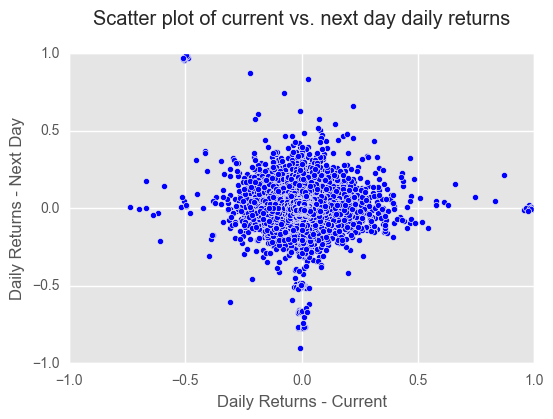

In [35]:
plt.style.use('ggplot')
fig = plt.figure()
ax = plt.scatter(Returns().transform(X_train).values, extract_Xy(Training, classify=False)[1].values)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('Daily Returns - Current')
plt.ylabel('Daily Returns - Next Day')
plt.title('Scatter plot of current vs. next day daily returns\n');

In [38]:
spearmanr_test(Returns().transform(X_train).values, extract_Xy(Training, classify=False)[1].values)

True

In [39]:
stats.spearmanr(Returns().transform(X_train).values, extract_Xy(Training, classify=False)[1].values)[0]

-0.027982112501992108

# Alpha Discovery Stage
I’ll be calculating fundamental and technical indicators (alphas) for the stock universe. Each alpha will be evaluated using the alphalens package to determine whether the alpha is predictive of future returns.

## Kalman Filters
The Kalman filter is an algorithm that uses noisz observations of a system over time to estimate the parameters of the system (some of which are unobservable) and predict future observations. At each time step, it makes a prediction, takes a measurement, and updates itself based on how the predictions and measurements compare.

It is important to consider that kalman filters assume that each measurement $z_k$ of the true value and some gaussian noise. Since market reutrns are often contain fatter tails data has to be preprocessed before being filtered.

In [127]:
from pykalman import KalmanFilter
from joblib import Parallel, delayed

'''
purpose: This custom transformer can be used in an sklearn pipeline.
         It uses a Kalman filter and linear regression to predict 
         future daily returns.
inputs:  X: Pandas DataFrame (Training/Testing Validation)
         period: Number of periods to calculate daily returns over
outputs: Daily returns values
credits: The basic implementation of Kalman filters for linear regression
         was taken from a Quantopian lecture on Kalman filters.
         The implementation has been altered to work in the context
         of an sklearn pipeline as a custom transformer.
'''

class KalmanRegressor(BaseEstimator, TransformerMixin):
    
    def __init__(self, observation_covariance=0.25, log=False):
        
         # This is an educated guess - potential for optimization
        self.observation_covariance = observation_covariance
        self.log = log
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        
        Results = pd.DataFrame(index=X.major_axis.unique().values, columns=X.items.unique())
        
        results = Parallel(n_jobs=16)(delayed(self.compute_kalman_regression)(X[ticker,:,'Close'], ticker) for ticker in X.items.unique())
        
        for index, ticker in enumerate(X.items.unique()):

            # Fill final DataFrame
            ticker = results[index].name
            Results[ticker] = results[index]
        
        return pd.DataFrame(Results.stack(dropna=False), columns=['Kalman Regression'])

    def compute_kalman_regression(self, close, ticker):
        
        if self.log == True:
            close = close.astype(float)
            observations = (np.log(close) - np.log(close.shift(1))).shift(-1)
            measurements = (np.log(close) - np.log(close.shift(1)))
            
        else:
            close = close.astype(float)
            observations = np.log(close.shift(-1)).pct_change(1)
            measurements = np.log(close).pct_change(1)

        observations = observations.fillna(observations.mean())
        measurements = measurements.fillna(measurements.mean())

        # 1: Choose state variables [a,b]
        x = 2

        # 2: Design state transition function
        F = np.eye(2)

        # 3: Designing the proxess noise matrix Q
        delta = 1e-3
        Q = delta / (1 - delta) * np.eye(2)

        # 5: Designing the measurement function H
        H = np.expand_dims(np.vstack([[measurements], [np.ones(len(measurements))]]).T, axis=1)

        # 6: Design measurement noise
        R = 1

        # Initialize KalmanFilter Class
        kf = KalmanFilter(n_dim_obs=1, n_dim_state=x,
                          initial_state_mean=[0,0],
                          initial_state_covariance=np.ones((2,2)),
                          transition_matrices=np.eye(2),
                          observation_matrices=H,
                          observation_covariance=self.observation_covariance,
                          transition_covariance=Q)

        # Batch processing - Online processing possible with .filter_update method
        state_means, state_covs = kf.filter(observations.values)

        # Calculate and return predicted values
        result = pd.Series(state_means[:,1] + state_means[:,0] * measurements)
        result.name = ticker
        return result

In [ ]:
start = time()
test = KalmanRegressor(log=False)
result = test.transform(X_train)

end = time()
print('The Kalman Filter has been calculated in {} seconds.'.format((end-start)))

In [ ]:
plt.style.use('ggplot')
fig = plt.figure()
ax = plt.scatter(result['Kalman Regression'], np.log(extract_Xy(Training, classify=False)[1].values))
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.xlabel('Daily Returns - Predicted')
plt.ylabel('Daily Returns - Next Day')
plt.title('Scatter plot of predicted vs. next day daily returns\n');

In [ ]:
stats.spearmanr(result['Kalman Regression'], extract_Xy(Training, classify=False)[1].values)

In [ ]:
spearmanr_test(result['Kalman Regression'], extract_Xy(Training, classify=False)[1].values)